<a href="https://colab.research.google.com/github/MammadovN/Machine_Learning/blob/main/projects/03_deep_learning/feedforward_neural_networks/Feedforward_Neural_Networks_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📦 Required Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Dataset: Wine Quality (Red Wine)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

df = pd.read_csv(url, sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
from sklearn.preprocessing import LabelEncoder

# Separate features and labels
X = df.drop("quality", axis=1).values
y_raw = df["quality"].values

# Encode labels to be 0-based (required for CrossEntropyLoss)
encoder = LabelEncoder()
y = encoder.fit_transform(y_raw)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✔️ Standart Ölçekleme
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✔️ Tensor formatına çevir
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# ✔️ DataLoader’lara sar
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# 🧠 Simple Feedforward Neural Network for Wine Quality Classification

class WineQualityFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim_2, output_dim):
        super(WineQualityFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [10]:
input_dim = X_train.shape[1]   # 11 features
hidden_dim = 128
hidden_dim_2=64
output_dim = len(np.unique(y))  # quality sınıf sayısı

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WineQualityFNN(input_dim, hidden_dim, hidden_dim_2, output_dim).to(device)

print(f"Model will run on: {device}")

Model will run on: cuda


In [12]:
# CrossEntropyLoss because it's a multi-class classification problem
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weights = torch.tensor(weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# 🔁 Training Function
def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=30):
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {train_losses[-1]:.4f} | Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies

In [14]:
train_losses, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 | Loss: 1.7814 | Test Accuracy: 42.81%
Epoch 2/100 | Loss: 1.6178 | Test Accuracy: 47.81%
Epoch 3/100 | Loss: 1.4954 | Test Accuracy: 47.19%
Epoch 4/100 | Loss: 1.4307 | Test Accuracy: 48.44%
Epoch 5/100 | Loss: 1.3785 | Test Accuracy: 48.12%
Epoch 6/100 | Loss: 1.3120 | Test Accuracy: 45.62%
Epoch 7/100 | Loss: 1.2723 | Test Accuracy: 44.38%
Epoch 8/100 | Loss: 1.2465 | Test Accuracy: 47.50%
Epoch 9/100 | Loss: 1.2285 | Test Accuracy: 44.38%
Epoch 10/100 | Loss: 1.2243 | Test Accuracy: 42.81%
Epoch 11/100 | Loss: 1.2026 | Test Accuracy: 47.50%
Epoch 12/100 | Loss: 1.2072 | Test Accuracy: 48.12%
Epoch 13/100 | Loss: 1.1465 | Test Accuracy: 46.88%
Epoch 14/100 | Loss: 1.1716 | Test Accuracy: 44.38%
Epoch 15/100 | Loss: 1.1167 | Test Accuracy: 44.38%
Epoch 16/100 | Loss: 1.1277 | Test Accuracy: 47.50%
Epoch 17/100 | Loss: 1.1473 | Test Accuracy: 45.94%
Epoch 18/100 | Loss: 1.1069 | Test Accuracy: 44.38%
Epoch 19/100 | Loss: 1.1175 | Test Accuracy: 45.00%
Epoch 20/100 | Loss: 

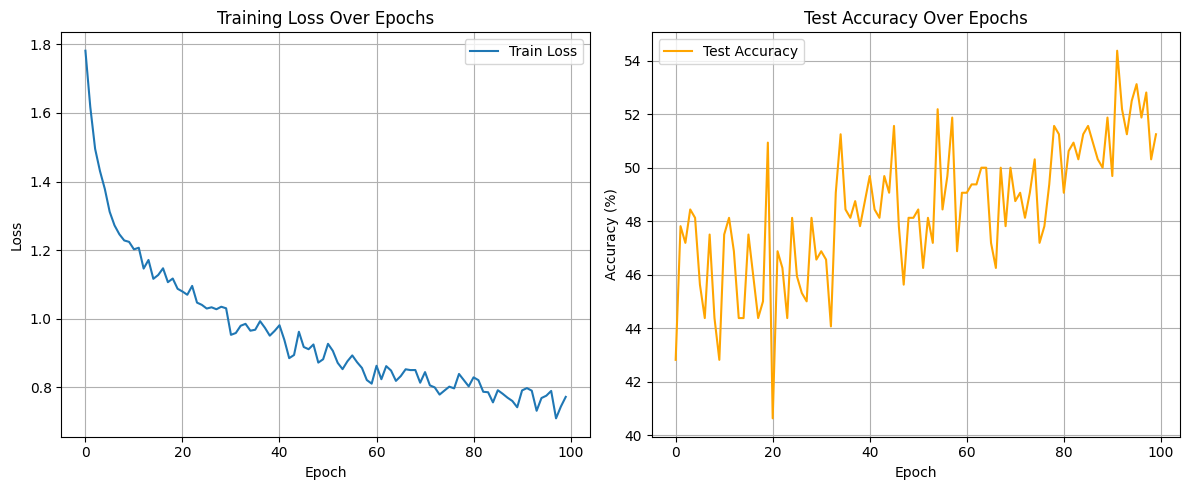

In [15]:
# 📊 Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Switch model to evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [17]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=encoder.classes_.astype(str)))

Classification Report:

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.15      0.70      0.25        10
           5       0.69      0.53      0.60       130
           6       0.59      0.42      0.49       132
           7       0.48      0.76      0.59        42
           8       0.08      0.20      0.11         5

    accuracy                           0.51       320
   macro avg       0.33      0.43      0.34       320
weighted avg       0.59      0.51      0.53       320



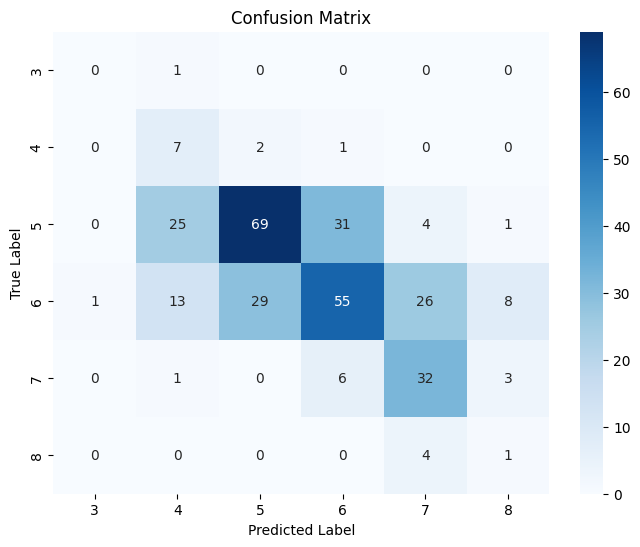

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()